Objetivos del Desafío

*   Analizar el conjunto de noticias y explicar los hallazgos principales
(tendencias, temas clave, patrones temporales, etc.).
*   Proponer e implementar una solución que integre inteligencia artificial
generativa y/o analítica para aportar valor sobre este corpus.


Los pasos a seguir para mi objetivo fueron:


1.   Limpieza y Busqueda de Feature .
2.   EDA para las variables "titulo","bajada" y "cuerpo".
3.   EDA para las secciones y medios de comunicación.
4.   Modelos (Bertopic con KMeans, KMeans y HDBSCAN)
5.   EDA de los topicos.






In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from IPython.display import display, HTML,Markdown



#Carga de datos

In [3]:
data=pd.read_excel("noticias_test_ingeniero_IA.xlsx")
data.head()

,Unnamed: 0,titulo,bajada,cuerpo,nombre_medio,tipo_medio,fecha,seccion
0,0,Provincial Ovalle empata sin goles como local...,NaN,LUCIANO ALDAY VILLALOBOS Ovalle En la tarde de...,El Ovallino,0,2025-05-31,Deportes
1,1,Natalidad en caída y ciencia,NaN,La reciente cifra entregada por el INE (Instit...,La Estrella El Diario de Chiloé,0,2025-05-31,Actualidad
2,2,"Turismo de lujo en Chile: experiencias únicas,...","Un mercado que ha crecido de forma sostenida, ...",El turismo ha experimentado una transformación...,La Tercera,0,2025-05-31,NaN
3,3,Mon Laferte tenía razón,NaN,Señor Director: Luego del lamentable hallazgo ...,El Mercurio,0,2025-05-31,OPINIÓN - CARTAS
4,4,El niño cordillera,NaN,A siete décadas de su hallazgo –realizado por ...,El Mercurio|Vivienda y Decoración,7,2025-05-31,suplemento


##Limpieza

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6399 entries, 0 to 6398
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    6399 non-null   int64         
 1   titulo        6399 non-null   object        
 2   bajada        3862 non-null   object        
 3   cuerpo        6399 non-null   object        
 4   nombre_medio  6399 non-null   object        
 5   tipo_medio    6399 non-null   int64         
 6   fecha         6399 non-null   datetime64[ns]
 7   seccion       5346 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 400.1+ KB


Se aprecia solamente seccion y bajada con valores NaN.

hago esto para el modelo

Remplazamos los NaN con un espacio y quitamos los elementos de HTML con "re", esperemos que no dañe algun texto especifico.

In [5]:
import re
data["bajada"]=data["bajada"].fillna("")
data["bajada"]=data["bajada"].apply(lambda x: re.sub(r'<.*?>', '', x))

Para el modelo no supervisado se utilizará una sola columna con el "titlo"+"bajada"+"cuerpo", esto ayudará con informacion adicional al modelo, tambien un paso recomendado es dejar el texto en minusculas.

In [6]:
data["titulo"]=data["titulo"].apply(lambda x : x.lower())
data["bajada"]=data["bajada"].apply(lambda x : x.lower())
data["cuerpo"]=data["cuerpo"].apply(lambda x : x.lower())

In [7]:
data["text_union"]=data["titulo"] +"."
data["text_union"]=data["text_union"].str.cat(data["bajada"].fillna(""))
data["text_union"] = data[["text_union","cuerpo"]].apply(lambda row: row["text_union"] + " " + row["cuerpo"] if row["text_union"].strip().endswith(".")else row["text_union"].strip() + ". " + row["cuerpo"],axis=1)


In [8]:
data["largo"]=data["text_union"].str.len()
data['num_palabras'] = data['text_union'].apply(lambda x: len(x.split()))

#EDA (texto)

[Text(0.5, 0, 'Total de palabras')]

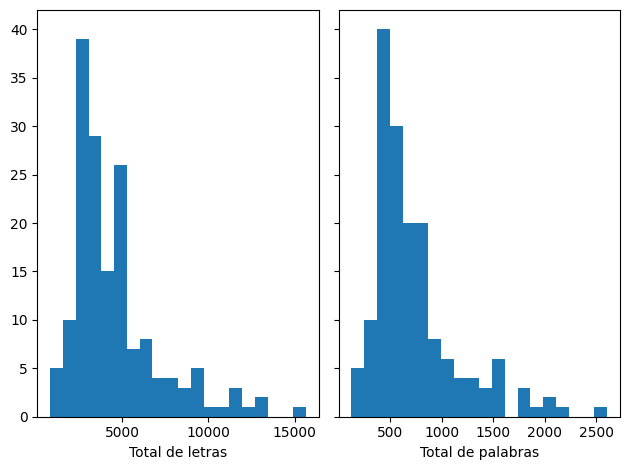

In [9]:
fig, axs =plt.subplots(1,2,sharey=True, tight_layout=True)
axs[0].hist(data[["largo","nombre_medio"]].groupby("nombre_medio").mean().values,bins=20)
axs[0].set(xlabel="Total de letras")
axs[1].hist(data[["num_palabras","nombre_medio"]].groupby("nombre_medio").mean().values,bins=20)
axs[1].set(xlabel="Total de palabras")


Histograma de la media de la cantidad de palabras y letras de cada medio de comunicaion, se aprecia una concentracion alrededor de las 3000 letras. En cambio la misma forma de histograma se encuentra en las 500 palabras de promedio.

###Duplicados

Preguntas con respecto a ello


*   Qué porcentaje corresponden las noticias copiadas con respecto a la cantidad de publicaciones de cada medio?
*   Cual noticia fue más repetida?
*   Qué medio de comunicion copia mas noticias?
*   Qué medio de comunicion produce más contenido original (primero que todos)?(no se respondió, Se necesitaban las horas)
*   Que noticia fue copiada por mas tiempo?





In [10]:
data.duplicated(keep=False).sum()

np.int64(0)

In [11]:
data[["titulo","bajada","cuerpo"]].apply(lambda x : x.duplicated(keep=False).sum(), axis=0)

,0
titulo,1742
bajada,3445
cuerpo,1135


In [12]:
temp1=data.apply(lambda x : x.duplicated(keep=False).sum(), axis=0)
temp2=data.apply(lambda x : x.nunique(), axis=0)

html = f"""
<div style="display: flex; gap: 20px;">
    <div>{temp1.to_frame().head(10).to_html()}</div>
    <div>{temp2.to_frame().head(10).to_html()}</div>
</div>
"""

display(HTML(html))

,0
Unnamed: 0,0
titulo,1742
bajada,3445
cuerpo,1135
nombre_medio,6377
tipo_medio,6399
fecha,6398
seccion,6185
text_union,997
largo,3955


In [13]:
final_data=data.drop_duplicates("text_union",keep="first")

In [14]:
df_dup = data[data["text_union"].duplicated(keep=False)].copy()
id_dup = df_dup.groupby(df_dup.columns.tolist()).apply(lambda x: x.index[0]).values.tolist()
df_dup["id_dup"]=df_dup.groupby('text_union').ngroup()

/tmp/ipython-input-14-1409691630.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  id_dup = df_dup.groupby(df_dup.columns.tolist()).apply(lambda x: x.index[0]).values.tolist()


In [15]:
data["text_union"][id_dup].duplicated(keep="first")

,text_union
15,False
18,True
21,True
23,True
28,True
...,...
6382,False
6383,False
6384,True
6386,True


Qué porcentaje corresponden las noticias copiadas con respecto a la cantidad de publicaciones de cada medio?

In [16]:
temp1=pd.concat([data["nombre_medio"].value_counts(),data["nombre_medio"][id_dup].value_counts()],axis=1).fillna(0)
temp1=temp1.set_axis(["total","total_copias"],axis=1)
temp1["proporcion"]=temp1["total_copias"]/temp1["total"]*100
html = f"""
<div style="display: flex; gap: 20px;">
    <div>{temp1.head(5).to_html()}</div>
    <div>{temp1["proporcion"].sort_values().to_frame().head(5).to_html()}</div>
    <div>{temp1["proporcion"].sort_values(ascending=False).to_frame().head(5).to_html()}</div>

</div>
"""

display(HTML(html))
display(Markdown("**Nota:** Los dos ultimos dataframes muestran los medios de comunicación con menos copias (noticia original) y con más copias, respectivamente."))


**Nota:** Los dos ultimos dataframes muestran los medios de comunicación con menos copias (noticia original) y con más copias, respectivamente.

Cuál noticia fue más repetida?

In [17]:
df_dup.groupby(['id_dup']).size().sort_values(ascending=False).head()

,0
id_dup,
281,15
299,10
210,8
266,7
243,7


In [18]:
print("Titular de la 1° noticia mas copiada: \"" + df_dup[df_dup["id_dup"]==275]["titulo"].head(1).iloc[0]+"\"")
print("Titular de la 2° noticia mas copiada: \"" + df_dup[df_dup["id_dup"]==293]["titulo"].head(1).iloc[0]+"\"")
print("Titular de la 3° noticia mas copiada: \"" + df_dup[df_dup["id_dup"]==298]["titulo"].head(1).iloc[0]+"\"")

Titular de la 1° noticia mas copiada: "rencort va por las golden cup u13 y u18"
Titular de la 2° noticia mas copiada: "sujetos roban cajero automático con cerca de $100 millones"
Titular de la 3° noticia mas copiada: "tohá a alcaldes por nueva cárcel: "lo entendemos, pero hay que construirla""


¿Qué medio de comunicion copia mas noticias?

In [19]:
data["nombre_medio"][id_dup].value_counts().head(10)

,count
nombre_medio,
La Estrella del Loa,80
La Estrella de Antofagasta,80
La Estrella de Tocopilla,72
HoyxHoy,69
HoyxHoy Concepción,57
El Diario de Atacama,55
El Mercurio de Calama,52
El Austral El Diario de Osorno,45
El Mercurio de Antofagasta,41


¿Qué noticia fue copiada por mas tiempo?

In [20]:
temp1=df_dup.groupby("id_dup").apply(lambda x:x["fecha"].max()-x["fecha"].min()).sort_values(ascending=False).head(4)

/tmp/ipython-input-20-2356055994.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp1=df_dup.groupby("id_dup").apply(lambda x:x["fecha"].max()-x["fecha"].min()).sort_values(ascending=False).head(4)


In [21]:
print("1° Titular de la noticia que fue copiada durante más tiempo ("+str(temp1.iloc[0].days)+" dias): \"" + df_dup[df_dup["id_dup"]==119]["titulo"].head(1).iloc[0]+"\"")
print("2° Titular de la noticia que fue copiada durante mas tiempo ("+str(temp1.iloc[1].days)+" dias): \"" + df_dup[df_dup["id_dup"]==185]["titulo"].head(1).iloc[0]+"\"")
print("3° Titular de la noticia que fue copiada durante mas tiempo ("+str(temp1.iloc[2].days)+" dias): \"" + df_dup[df_dup["id_dup"]==68]["titulo"].head(1).iloc[0]+"\"")

1° Titular de la noticia que fue copiada durante más tiempo (7 dias): "duelo entre el capitán picón y el profesor vicuña"
2° Titular de la noticia que fue copiada durante mas tiempo (6 dias): "hombre recibe 12 impactos de bala en un local de comida rápida"
3° Titular de la noticia que fue copiada durante mas tiempo (5 dias): "claves ipsos: 9 de cada diez personas sienten orgullo de ser chilenas y un 68% reconoce que conviven diversas identidades culturales en el país"


#EDA (seccion y medios)

Una pregunta para estos datos seria, que seccion fue mas repetida por cada medio? y cual fue su proporcion con respecto al total de sus publicaciones?

Esto puede dar una indicador de si:

*   un medio es muy dependiente de una seccion.
*   cual es la seccion más atrayente (pensando que el medio publica en dicha seccion segun la cantidad usuarios que la ven)
*   si una seccion predomina en un medio y esto provoca que se desvie de su publico inicial (por ejemplo un diario que se vende como medio de noticias nacionales, pero la mayoria de sus secciones son de espectaculos o deportes.)


In [22]:
html = f"""
<div style="display: flex; gap: 20px;">
    <div>{final_data["nombre_medio"].value_counts().to_frame().head(10).to_html()}</div>
    <div>{final_data["seccion"].value_counts().to_frame().head(10).to_html()}</div>
</div>
"""

display(HTML(html))

,count
nombre_medio,
El Trabajo,608
El Observador Quillota - Aconcagua,537
El Mercurio,338
La Tercera,259
Las Últimas Noticias,233
El Mercurio de Valparaiso,225
Diario Oficial,148
El Labrador,105
El Rancagüino,101


Estos dataframe muestra la cantidad de publicaciones de cada medio de comunicaion, entre los principales creadores estan "El Trabajador", "El Observador Quillota - Aconcagua" y "El Mercurio". Por otro lado el DF de la derecha coresponde a la cantidad de secciones repetidas, esto una señal de caetgorias mas importantes o llamativas para el publico en general, estas son:"Actualidad", "Deporte" y "Crónica" (sin considerando duplicados).

In [23]:
temp=data['nombre_medio'].value_counts()>100
temp.drop(temp[temp == False].index, inplace=True)
id_100=temp.index.to_list()

In [24]:

temp1=data.groupby(["nombre_medio","seccion"]).size()
conteo_df = temp1.reset_index(name="cuentas")
seccion_popular = conteo_df.loc[conteo_df.groupby("nombre_medio")["cuentas"].idxmax()]
seccion_popular=seccion_popular[seccion_popular["nombre_medio"].isin(id_100)]


In [25]:
total=data["nombre_medio"].value_counts()
total=total.reset_index()
total=total[total["nombre_medio"].isin(id_100)]
seccion_popular=seccion_popular.merge(total,how="inner")
seccion_popular=seccion_popular.set_index("nombre_medio").rename(columns={"count":"total"})

In [26]:
seccion_popular["porcentaje"]=seccion_popular['cuentas']/seccion_popular["total"]*100

In [27]:
seccion_popular.sort_values("porcentaje",ascending=False)

,seccion,cuentas,total,porcentaje
nombre_medio,,,,
El Lider San Antonio,Actualidad,80,108,74.074074
El Mercurio de Valparaiso,Actualidad,147,237,62.025316
El Labrador,Rodeo,60,105,57.142857
Las Últimas Noticias,El Día,120,238,50.420168
El Rancagüino,Deportes,44,101,43.564356
El Mercurio,Nacional,107,338,31.656805
El Trabajo,Crónica,167,608,27.467105
La Tercera,Nacional,71,262,27.099237
El Llanquihue,Actualidad,27,102,26.470588


Se aprecia unos medios abusan de ciertas secciones, lo que no esta mal, a menos que diarios como el "El Rancagüino" tienen como funcion dar informar el acontecer a una region, en cambio se concnetran en un 43% de su contenido en el deporte.

Haciendo una busqueda rapida " https://es.wikipedia.org/wiki/El_Rancag%C3%BCino ", me enteré que este diario tiene criticas severas "ha sido objeto de críticas en la región por la nula o escasa cobertura de hechos cubiertos por medios nacionales."

Una mejor analisis se podria conseguir con la entropia de shannon

#Model

En esta seccion se tiene como objetivo realizar cluster para poder identificar la categoria de noticias. Se propusieron dos modelos KMeans y HDBSCAN, usando embedding con el modelo BERT, además se utilizó modelos de reduccion de dimension, especificamente PCA, T-SNE y UMAP, con el fin de tener un mejor score en los modelos.

##BERT

In [ ]:
!pip install --upgrade bertopic;

In [29]:
import bertopic as BT

In [30]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn. metrics  import silhouette_score
from sklearn.decomposition import PCA

Para el uso de BERT se escogio un modelo de multiples idiomas, debido que por defecto los medelos se entrenan con datos en ingles.

Este codigo se contruye el embedding para el modelo KMeans y hdbscan

In [32]:
from sentence_transformers import SentenceTransformer

#model = SentenceTransformer("all-MiniLM-L6-v2")
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
embeddings = model.encode(final_data["text_union"].tolist(), show_progress_bar=True)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/179 [00:00<?, ?it/s]

In [33]:
data["fecha"].dt.year.unique() #Reviso los años para incorporarlo al stopwords

array([2025, 2024], dtype=int32)

In [34]:
#spanish_stopwords en su mayoria generada por chatgpt
spanish_stopwords = ["es","ese","de", "la", "que", "el", "en", "y", "a", "los", "del", "se","él", "las", "por", "un", "para",
                     "con", "no", "una", "su", "al", "lo", "como", "más", "pero", "sus", "le", "ya", "o", "este",
                     "sí", "porque", "esta", "entre", "cuando", "muy", "sin", "sobre", "también", "me", "hasta",
                     "hay", "donde", "quien","ha","han","son","fue","era","mi","tu","tiene","si","2024","2025","era",
                     "qué","yo"]

vectorizer_model = CountVectorizer(stop_words=spanish_stopwords)

In [35]:
dim_model = PCA(n_components=15)
kmeans_bert = KMeans(n_clusters=20,random_state=42)

bert_model = BT.BERTopic(umap_model=dim_model, embedding_model="paraphrase-multilingual-MiniLM-L12-v2",
                      vectorizer_model=vectorizer_model, hdbscan_model=kmeans_bert,
                      calculate_probabilities=True)
topics, probabilities = bert_model.fit_transform(final_data['text_union'].sample(300).tolist())

Ahora mostrando el titulo de la noticia representativa y el topico, a simple vista se ve una buena clasificación.

In [36]:
model_bert_info=bert_model.get_topic_info()
for i in model_bert_info["Topic"].unique()[:7]:
  print("El cluster n°: ",model_bert_info["Name"][i])
  print("Titulo de la noticia representativa: ")
  print(model_bert_info[model_bert_info["Topic"]==i]["Representative_Docs"].to_list()[0][0][:100],"...")
  print("")

El cluster n°:  0_cve_spa_vinos_chile
Titulo de la noticia representativa: 
la historia del vino imaginado que se volvió número uno.es el enólogo emblemático de 'don melchor',  ...

El cluster n°:  1_investigación_carabineros_denuncia_delitos
Titulo de la noticia representativa: 
diputado durán es acusado de abuso en medio de dichos cruzados.parlamentario aseguró que fue una rel ...

El cluster n°:  2_sequías_desde_estudio_chile
Titulo de la noticia representativa: 
"la mejor guía de viajes del mundo" cumple 100 años.desde hace mucho tiempo se ha predicho la muerte ...

El cluster n°:  3_cve_solicitud_extracto_decreto
Titulo de la noticia representativa: 
sea declaró no admisible proyecto por un millón de dólares en nueva braunau.educación. al menos tres ...

El cluster n°:  4_accidente_conductor_camión_cuerpo
Titulo de la noticia representativa: 
piden revisar protocolos de seguridad tras accidente de trabajador en el canal.hombre de 57 años suf ...

El cluster n°:  5_millones_hogares

###Metricas

Se me ocurrió utilizar todos los topicos optenidos por el modelo y averiguar si son unicos, esto me puede indicar que los grupos estan bien separados. Pero esto no es una metrica definitiva que nos pueda guiar en un buen modelo.

In [37]:
temp=[]
for i in range(0,20):
  temp += model_bert_info["Representation"][i]
print("cantidad de topicos unicos: ",len(set(temp)),"y cantidad total: ",len(temp))
print("proprocion :", len(set(temp))/len(temp))

cantidad de topicos unicos:  177 y cantidad total:  200
proprocion : 0.885


Este valor cercano a uno, indica que la mayoria de topicos selecionados por el modelo son unicos para cada cluster.

###Data topics

In [38]:
topics, prop = bert_model.transform(final_data["text_union"].to_list())

In [39]:
data_cluster_topic=pd.DataFrame({"titular":final_data["titulo"],"text_union":final_data["text_union"],"seccion":final_data["seccion"],"date":final_data["fecha"],"topic":topics})

In [40]:
data_cluster_topic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5727 entries, 0 to 6398
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   titular     5727 non-null   object        
 1   text_union  5727 non-null   object        
 2   seccion     4711 non-null   object        
 3   date        5727 non-null   datetime64[ns]
 4   topic       5727 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 268.5+ KB


##KMeans

Ahora utilizando kmeans a secas, solamente con el embeddings del modelo BERT.

Primero se utilizó el metodo del codo para encontrar el numero de cluster apropiado.

In [41]:
scores = []
K_range = range(10, 30)

for k in K_range:
    kmeans = KMeans(n_clusters=k,n_init=15,random_state=42)
    labels = kmeans.fit_predict(embeddings)
    scores.append(kmeans.inertia_)



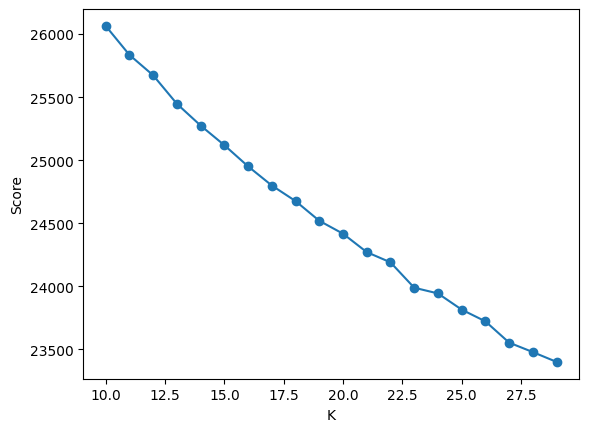

In [42]:
plt.plot(K_range, scores, marker='o')
plt.xlabel('K')
plt.ylabel('Score')
plt.show()

El metodo del codo no arrojo buenos resultados haciendo variar los cluster de 10 a 30, se usaran 28 k para el modelo final.

In [43]:
kmeans_28 = KMeans(n_clusters=28,n_init=15,random_state=42)
labels_28=kmeans_28.fit_predict(embeddings)

kmeans_10 = KMeans(n_clusters=10,n_init=15,random_state=42)
labels_10=kmeans_10.fit_predict(embeddings)

Se utilizó T-sne para visualizar los grupos,para falicitar se eligió 10 k.

In [44]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)



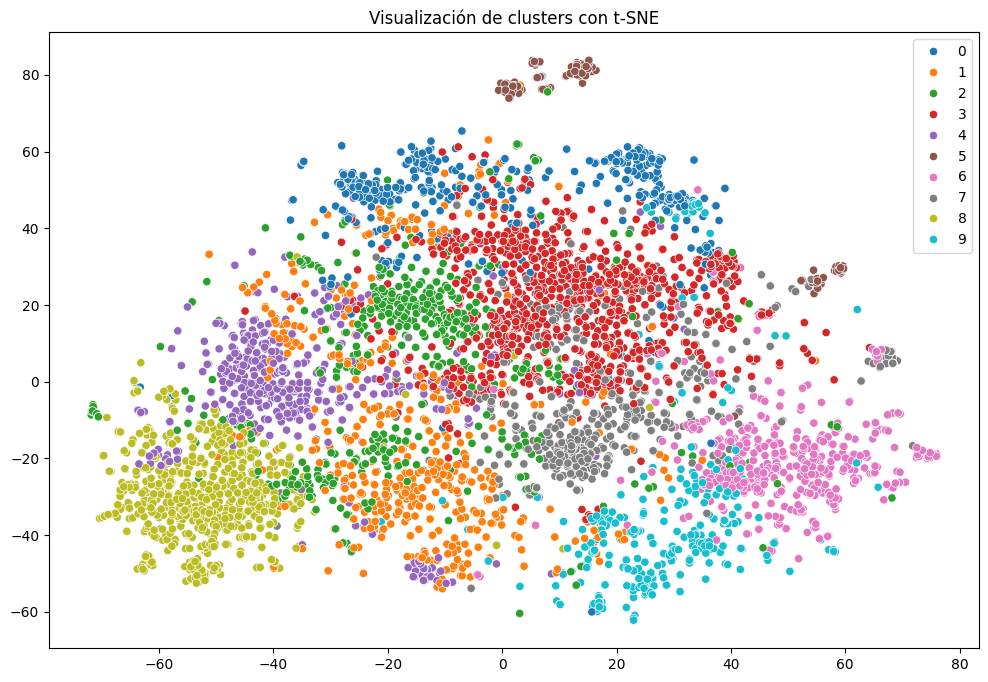

In [45]:
# Visualización
plt.figure(figsize=(12, 8))
sns.scatterplot(x=embeddings_tsne[:,0], y=embeddings_tsne[:,1], hue=labels_10, palette='tab10')
plt.title("Visualización de clusters con t-SNE")
plt.show()

Usando solamente 10 cluster se puede apreciar grupos bien definidos a simple vista, no hay que descartar que presentan varios cruces entre grupos y varios outlier.

In [46]:
data_cluster_kmeans=pd.DataFrame({"titular":final_data["titulo"],"text_union":final_data["text_union"],"seccion":final_data["seccion"],"labels":labels_28})

In [47]:
for i in data_cluster_kmeans["labels"].unique()[:7]:
  print("El cluster n°: ",i)
  print("Algunos titulares y secciones: ")
  print(data_cluster_kmeans[data_cluster_kmeans["labels"]==i][["titular","seccion"]].head(3),)

El cluster n°:  13
Algunos titulares y secciones: 
                                              titular            seccion
0   provincial ovalle empata sin goles  como local...           Deportes
7   el ancla busca saldar una deuda pendiente en e...           Deportes
11  trasandino debe ganar si quiere seguir soñando...  Trabajo Deportivo
El cluster n°:  2
Algunos titulares y secciones: 
                                              titular     seccion
1                        natalidad en caída y ciencia  Actualidad
13  seremi del trabajo realizó charla por reforma ...   Comunidad
37  vecinos de villa el remanso denuncian aumento ...         NaN
El cluster n°:  21
Algunos titulares y secciones: 
                                              titular               seccion
2   turismo de lujo en chile: experiencias únicas,...                   NaN
3                             mon laferte tenía razón      OPINIÓN - CARTAS
33  "cuando uno logra enamorarse del proyecto, pon...   - gerenc

Leyendo algunos cuerpos de noticias, es posible identificar algunos cluster, con una categoria especifica, por ejemplo, leyendo las 3 noticias mostradas:

*   Cluster 8: "Superación", "Historia de vida"
*   Cluster 13: "Deportes"
*   Cluster 1: "Crimen", "Policial"
*   Cluster 14: "Turismo"




Pero tambien se aprecian cluster dificiles de interpretar (cluster 21 o 2) y repetidos como el cluster 25.

Esto más que errores, pueden dar una mejor vision de como se puede armar una seccion en un medio de comunicacion, es posible que el cluster 2 si tenga un publico objetivo que no se haya estudiado, tambien el cluster repetido (25) puede ser una subseccion o una diferente a "deportes" en una revista deportiva. Esto comprueba la necesidad de seguir estudiando nuevas estrategias y tegnologias para el modelo asi tener una mejor categorizacion y resolver la problematica propuesta.




##HDBSCAN


Ahora intentar con HDBSCAN, un cluster que se basa en la densidad.

In [48]:
import hdbscan
import umap.umap_ as umap
reducer = umap.UMAP(n_components=5, random_state=42)
embedding_reduce = reducer.fit_transform(embeddings)

clusterer = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=5, metric='euclidean')
labels_umap = clusterer.fit_predict(embedding_reduce)

In [49]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=5, metric='euclidean')
labels_tsne = clusterer.fit_predict(embeddings_tsne)

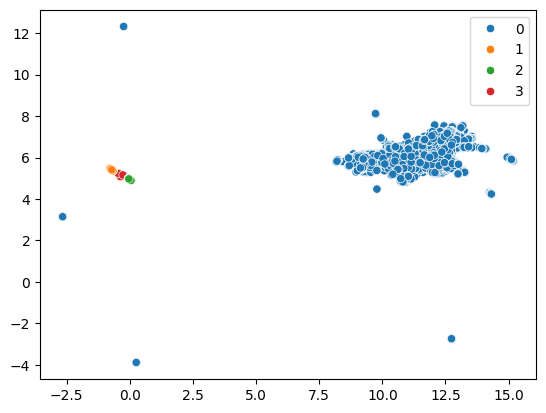

In [50]:
sns.scatterplot(x=embedding_reduce[:, 0], y=embedding_reduce[:, 1], hue=labels_tsne, palette='tab10');

para HDBSCAN, se intento cambiar la cantidad minima de cluster, usar umap y t-sne para reducir el embedding, pero no se encontró una configuracion de parametros o estrategias para poder clasificar adecuadaamente, debiddo a que arrojaban más de 60 clusters, no dudo de que los datos si tengan esa cantidad de secciones o que se aplicase de manera erronea una estrategia para el modelo. Pero si destacar que el objetivo principal puede llegar más complejo de lo que se pensó.

##Comparacion usando silhouette

silhouette_score mide la distancia promedio de puntos con su correspondiente cluster, la funcion arroja un valor entre -1 y 1, siendo -1 un modelo horrible y 1 el perfecto.

In [51]:
#Kmeans 12 minutos aprox
#silueta_promedio_BERT_kmeans = silhouette_score(model.encode(final_data["text_union"].tolist(), show_progress_bar=True), topics)
#print("Puntuación de silueta para Kmeans:", silueta_promedio_BERT_kmeans)
#Puntuación de silueta para Kmeans: 0.026624138

Batches:   0%|          | 0/179 [00:00<?, ?it/s]

Puntuación de silueta para Kmeans: 0.026624138


In [52]:
#Kmeans
silueta_promedio_kmeans = silhouette_score(embeddings, labels_28)
print("Puntuación de silueta para Kmeans:", silueta_promedio_kmeans)

Puntuación de silueta para Kmeans: 0.040312752


In [53]:
#HDBS umap
silueta_promedio_HDBS_umap = silhouette_score(embedding_reduce, labels)
print("Puntuación de silueta HDBS umap:", silueta_promedio_HDBS_umap)


Puntuación de silueta HDBS umap: 0.056332104


Sin juzgar el resultado, ambos modelos arrojan un score no satisfactorio para el objetivo. Esto da a entender la posibilidad de buscar un modelo mas preciso.

#EDA (con Sub_etiquetas)

###Visualizacion

Histograma de la cantidad de noticias con cierto topico, tener muchos Counts puede ser un indicador de ruido o outliers.

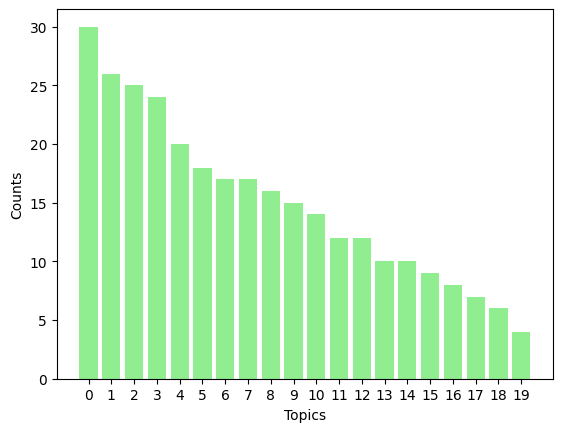

In [54]:

plt.bar(model_bert_info["Topic"],model_bert_info["Count"],color='lightgreen')
plt.xlabel("Topics");plt.ylabel("Counts")
plt.xticks(range(0,20));

La siguiente linea muestra los topicos en dimensoines reducidas (2D), la razon del por que los topicoss estan uno enciam de otros, puede ser debido a que comparten similitud. Pero explorando con la barra horizontal de la parte inferior, no todos tienen mucha similutdes, por ejemplo el topico 14 que corresponde talvez a "Accidentes", esta junto del topico 17 que indica Deportes, pero tambien el topico 5 de cultura esta junto a "religio"o "fiestas".

In [55]:
bert_model.visualize_topics()

El siguiente visual, corresponde al peso que contienen ciertas palabras en los topicos. Se puede indentificar tanto topicos coherentes como enormes sesgos.

Por ejemplo el topico 1 puede asociarse con "Policial" o "accidentes", el topico 2 con "Sequias" o "Medio ambiente", el 4 a "accidentes".


In [56]:
bert_model.visualize_barchart()

Mapa de calor entre los topicos, entre más azul mas similares son, se puede interactuar con el mause, pasando por el grafico se muestra la similitud. Si revisamos el topico 6 que se relaciona con el deporte, tiene mucha similitud con topicos 13, 16 y 17, estos topicos puede ser o el mismo o subsecciones de una revista deportiva que abarque mas temas.

In [57]:
bert_model.visualize_heatmap()

La jerarquia muestra cuanto más bajo se unen dos tópicos, más similares son. Cuanto más conexiones hayan entre ellos, más diferentes son entre si.

In [58]:
bert_model.visualize_hierarchy()

Tengo entendido que las ultimas dos visualizaciones utilizan el metodo c-TF-IDF para hacere la smilitud.

##Topicos

Despues de este analisis se podrian hacer las siguientes categorias:



*   "Policial": 1
*   "Sequias" o  "Medio ambiente": 2
*   "Accidente" o "crimen": 4
*   "Finanzas" o "Ofertas": 5
*   "Deportes": 6, 16, 13 y 17 (sesgado)
*   "Chile-Argentina" o "Internacional": 8  
*   "Religion" o "Celebraciones": 9
*   "Ciencia": 11
*   "Alerta ambiental": 12
*   "Salud": 14
*   "Politica": 15
*   "Naturaleza" o "Medio ambiente": 19
*   "Turismo" o "Cultura": 18
*   Impreciso: 0, 3 y 7

















###Elecciones municipales

El siguiente paso seria comprobar algunos de estos topicos, para ello busqué algunas noticias que debieron provocar un peak de publicaciones, esto se vera en un grafico  donde sumé la cantidad de cada seccion en cada fecha.

Supuse que las elecciones municipales realizadas el 26 y 27 de octubre debieron provocar un peak, para ello grafique en el tiempo la cantidad de publicaciones con el topico 15 (Gobierno).

Observando el grafico, se confirma mi hipotesis.

In [76]:
temp1=data_cluster_topic[["date","topic"]].value_counts().reset_index().sort_values("date")

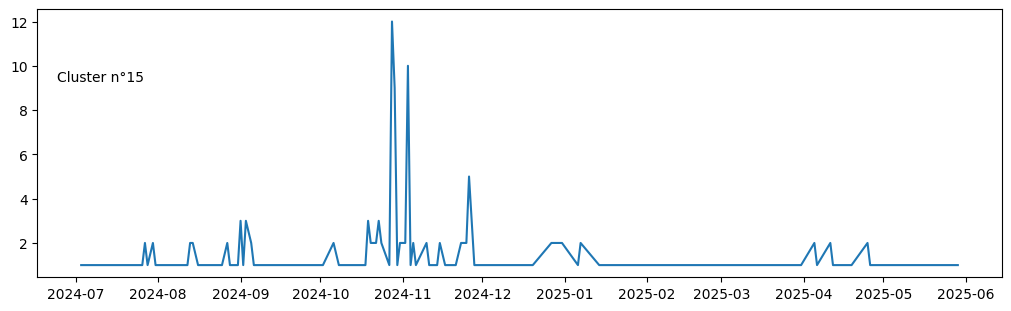

In [79]:
fig, axs = plt.subplots(1, 1, figsize=(10, 3), layout='constrained')
temp=temp1[temp1["topic"]==15]
axs.set_title("Cluster n°"+str(15), loc='left', y=0.7, x=0.02, fontsize='medium')
axs.plot(temp["date"],temp["count"])


In [81]:
data[data["fecha"]=="2024-10-28"]["titulo"].head() # confirmado

,titulo
3925,el balance de género: comunas lideradas por mu...
3926,republicanos logra tímidos resultados y no cum...
3927,"frente amplio conserva comunas clave, pero rec..."
3928,claves para entender la elección
3929,mario desbordes se declara vencedor: “soy el a...


###Navidad

En cambio para el topico de celebraciones o religion, no tiene peak importantes en la fecha de navidad. Pero revisando el dataframe no encuentro titulares donde mencionen la navidad. Por lo que no puedo confirmar si el modelo funciona adecuadamente para este tipo de noticias.

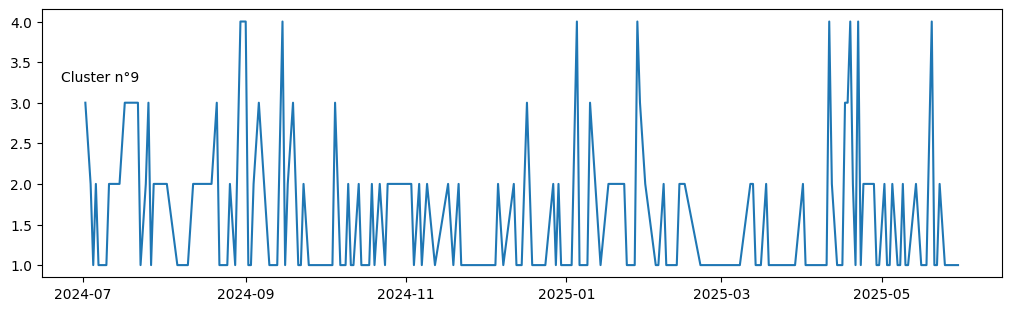

In [82]:
fig, axs = plt.subplots(1, 1, figsize=(10, 3), layout='constrained')
temp=temp1[temp1["topic"]==9]
axs.set_title("Cluster n°"+str(9), loc='left', y=0.7, x=0.02, fontsize='medium')
axs.plot(temp["date"],temp["count"])

In [85]:
data[data["fecha"]=="2024-12-25"]["titulo"].head()

,titulo
2967,"descubren 27 nuevas especies, incluido un rató..."
2968,construcción de bodegas cierra 2024 con su niv...
2969,"descubren 27 nuevas especies, incluido un rató..."
2970,"descubren 27 nuevas especies, incluido un rató..."
2971,"descubren 27 nuevas especies, incluido un rató..."


### Caso del diputado Duran

Para el topico 1  correspondientes a casos policiales, se encuentra un peak el dia 12 de febrero, dias cercanos cuando se dio a conocer el caso de abuso de Duran

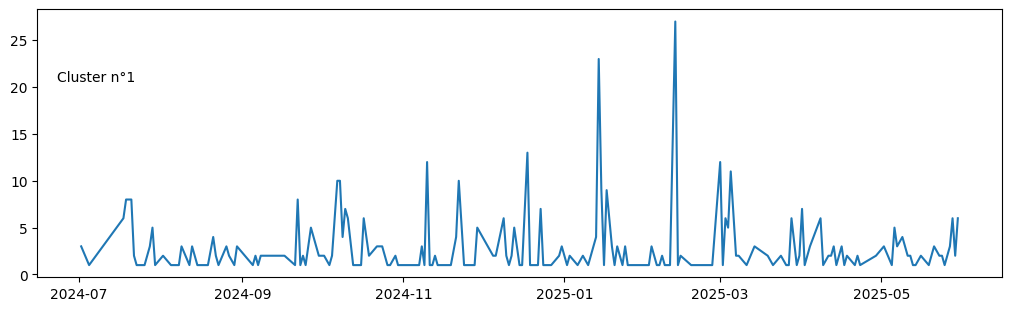

In [86]:
fig, axs = plt.subplots(1, 1, figsize=(10, 3), layout='constrained')
temp=temp1[temp1["topic"]==1]
axs.set_title("Cluster n°"+str(1), loc='left', y=0.7, x=0.02, fontsize='medium')
axs.plot(temp["date"],temp["count"])

In [84]:
data[data["fecha"]=="2025-02-12"]["titulo"].head()

,titulo
1932,ex pareja acusa a diputado jorge durán de abus...
1933,ex pareja acusa a diputado jorge durán de abus...
1934,cae banda que ingresó metanfetamina por el aer...
1935,diputado durán es acusado de abuso en medio de...
1936,diputado duran es acusado de abuso en medio de...


###Graficos para varios topicos

De forma general se graficaron de la misma manera algunos topicos:

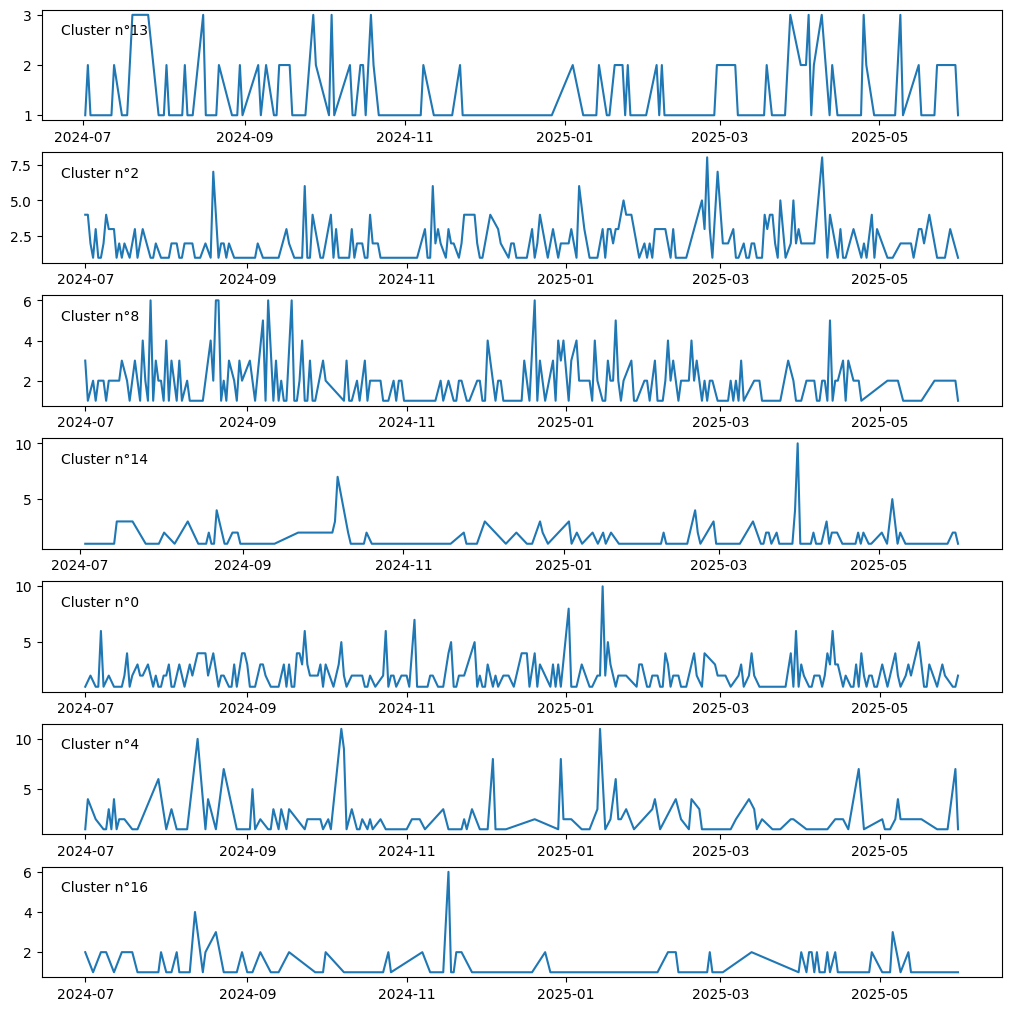

In [88]:
fig, axs = plt.subplots(7, 1, figsize=(10, 10), layout='constrained')
temp1 = data_cluster_topic[["date","topic"]].groupby(["date","topic"]).value_counts()
temp1 = temp1.reset_index()
for idx,i in  enumerate(data_cluster_topic["topic"].unique()[0:7]):
  temp=temp1[temp1["topic"]==i]
  axs[idx].set_title("Cluster n°"+str(i), loc='left', y=0.7, x=0.02, fontsize='medium')
  axs[idx].plot(temp["date"],temp["count"])

#Conclusión

El objetivo del proyecto que era resolver la problematica de las secciones se logró de forma parcial, teniendo varios topcios que acertaban en el tipo de noticias, pero tambien algunos donde se apreciaba un sesgo importante. Si bien el modelo usando `BERT con KMeans` logro predecir bien algunas noticias (mostradas en los peak), tiene sesgos importantes que inpiden seguir avanzando en entrenar algun modelo supervisado.

El analisis exploratorio mostro varios datos interesantes como el hecho de que algunos medcios de comunicaciones copiaban casi el 100% de sus publicaciones, tambien destacar a los que no lo hacian y se le podria asociar como noticias originales, tambien el hecho de mostrar medios que se desvian de su objetivo principal prefiriendo una seccion en particular como el caso del "El rancagûino".

En cuanto a los modelos `KMeans` y `BRET con KMeasn` pudieron cumplir con facilidad su funcion de predecir tipos de noticias, el modelo `HDBSCAN` dejo de que desear opteniendo un numero no satisfactorio de cluster. Visualizamos los resultados con UMAP y `.visualize_()`, confirmando que los grupos formados reflejan temas (por ejemplo, deportes, política, cultura).

##Futuro trabajos

Queda pendiente entrenar un mejor modelo, talves BERT con HDBSCAN o buscar nuevos feature, como la incorporacion de funciones de parafraseo que entregan mas informacion al modelo, tambien utilizazr TDA o IA generativa para seleccionar correctamente los topicos del modelo entrenado. Tambien explorar nuevas herramientas como redes recurrentes con BERT o buscar librerias que un buen uso de stopwords en español.
Tambien como se mencionó en la conclusion, implementar un modelo supervisado, para que nuevas noticias pueda ser clasificadas y tener un codigo automatizado.